# English descriptions

In [3]:
import os
import xml.etree.ElementTree as ET
from collections import Counter

folder = "./xml/20250903"
lang_counts = Counter()

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = ET.parse(filepath)
            root = tree.getroot()
            for desc in root.findall(".//description"):
                lang = desc.attrib.get("lang")
                if lang:
                    lang_counts[lang] += 1
        except Exception as e:
            print(f"Error parsing {file}: {e}")

print("Language counts:")
for lang, count in lang_counts.items():
    print(f"{lang}: {count}")


Language counts:
en: 2524
fr: 178
de: 368


# Investigate headings

In [5]:
import os
import xml.etree.ElementTree as ET
from collections import Counter

folder = "./xml/20250903"

heading_counts = Counter()
headings_per_doc = {}

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = ET.parse(filepath)
            root = tree.getroot()
            
            # Find <description id="desc" lang="en">
            desc = root.find(".//description[@id='desc'][@lang='en']")
            if desc is not None:
                headings = desc.findall(".//heading")
                
                # Count headings per doc
                headings_per_doc[file] = len(headings)
                
                # Count normalized heading text
                for h in headings:
                    if h.text:
                        heading_counts[h.text.strip().upper()] += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

In [6]:
print("Most common headings (normalized):")
for heading, count in heading_counts.most_common(20):
    print(f"{heading}: {count}")

Most common headings (normalized):
BRIEF DESCRIPTION OF THE DRAWINGS: 610
BACKGROUND: 515
DETAILED DESCRIPTION: 473
TECHNICAL FIELD: 412
SUMMARY: 411
SUMMARY OF THE INVENTION: 226
BACKGROUND ART: 197
BACKGROUND OF THE INVENTION: 175
BRIEF DESCRIPTION OF DRAWINGS: 167
DESCRIPTION OF EMBODIMENTS: 139
FIELD OF THE INVENTION: 136
EXAMPLES: 126
SUMMARY OF INVENTION: 123
CITATION LIST: 121
TECHNICAL PROBLEM: 120
SOLUTION TO PROBLEM: 105
PATENT LITERATURE: 99
REFERENCE SIGNS LIST: 97
FIELD: 95
DETAILED DESCRIPTION OF THE INVENTION: 87


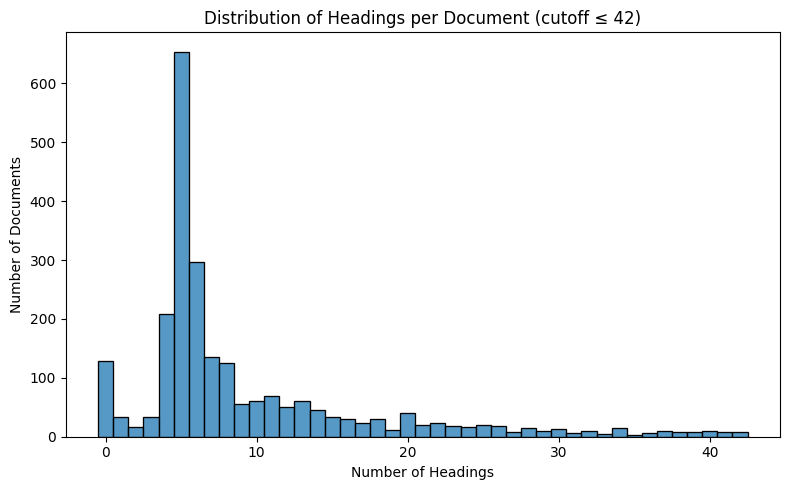

In [10]:
import numpy as np

counts = list(headings_per_doc.values())

# 95th percentile cutoff
cutoff = int(np.percentile(counts, 95))
trimmed_counts = [c for c in counts if c <= cutoff]

plt.figure(figsize=(8,5))
sns.histplot(trimmed_counts, bins=range(min(trimmed_counts), max(trimmed_counts)+2), discrete=True)

plt.title(f"Distribution of Headings per Document (cutoff ≤ {cutoff})")
plt.xlabel("Number of Headings")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()


> Using headings seems like a nightmare, not standardized enough

# XML tags in description

In [11]:
import os
import xml.etree.ElementTree as ET
from collections import Counter

folder = "./xml/20250903"
tag_counter = Counter()

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = ET.parse(filepath)
            root = tree.getroot()

            # Loop over all <description> blocks
            for desc in root.findall(".//description"):
                for elem in desc.iter():
                    if elem is not desc:  # exclude the <description> itself
                        tag_counter[elem.tag] += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

In [14]:
print("Most common tags inside <description>:")
for tag, count in tag_counter.most_common(100):
    print(f"{tag}: {count}")


Most common tags inside <description>:
p: 329384
entry: 291823
figref: 146730
sub: 106620
b: 87420
li: 74431
i: 71646
row: 59992
mi: 56017
sup: 44841
heading: 35253
mo: 31743
text: 26996
colspec: 24245
img: 21700
mn: 19392
patcit: 19223
dt: 14503
dd: 14503
msub: 13815
mfenced: 12478
chemistry: 12319
u: 9837
ul: 9540
nplcit: 7773
mrow: 7056
maths: 6520
br: 6512
math: 6236
tgroup: 4561
tbody: 4561
tables: 4383
mtd: 4171
table: 3887
mspace: 3752
thead: 3685
msubsup: 3006
mfrac: 2955
title: 2714
mtr: 2329
msup: 2213
mover: 2033
ol: 1669
dl: 983
mstyle: 967
mtable: 799
msqrt: 371
sub2: 344
o: 309
formula-text: 218
munder: 208
munderover: 203
mtext: 115
pre: 99
none: 75
mmultiscripts: 41
mprescripts: 41
sup2: 19
malignmark: 17
menclose: 16
maligngroup: 8
mroot: 6


# Clean tags

In [ ]:
from lxml import etree
import os

DROP_TAGS = {
    "chemistry", "heading", "img", "maths",
    "table", "tgroup", "row", "entry", "colspec", "tbody"
}

UNWRAP_TAGS = {"b", "i", "u", "sup", "sub", "br", "p", "patcit", "figref", "li", "ul", "ol"}

def aggressive_clean(desc_elem):
    # Unwrap allowed tags first
    for tag in UNWRAP_TAGS:
        for elem in desc_elem.findall(f".//{tag}"):
            parent = elem.getparent()
            if parent is None:
                continue
            text_to_add = (elem.text or "") + (elem.tail or "")
            if parent.text:
                parent.text += text_to_add
            else:
                parent.text = text_to_add
            parent.remove(elem)

    # Remove all remaining unwanted tags
    for tag in DROP_TAGS:
        for elem in desc_elem.findall(f".//{tag}"):
            parent = elem.getparent()
            if parent is not None:
                parent.remove(elem)

    # Extract text
    cleaned_text = " ".join(desc_elem.itertext())
    cleaned_text = " ".join(cleaned_text.split())  # normalize whitespace

    return cleaned_text

# Folder with XML files
folder = "./xml/20250903"
output_file = "cleaned_descriptions.txt"

with open(output_file, "w", encoding="utf-8") as f_out:
    for file in os.listdir(folder):
        if file.endswith(".xml"):
            filepath = os.path.join(folder, file)
            try:
                tree = etree.parse(filepath)
                root = tree.getroot()
                desc = root.find(".//description[@id='desc'][@lang='en']")
                if desc is not None:
                    text = aggressive_clean(desc)
                    if text:
                        f_out.write(text + "\n")
            except Exception as e:
                print(f"Error parsing {file}: {e}")

print(f"All cleaned descriptions saved to {output_file}")


All cleaned descriptions saved to cleaned_descriptions.txt


# Cleaned and remove first and last paragraphs

In [ ]:
from lxml import etree
import os

# Tags to remove completely
DROP_TAGS = {
    "chemistry", "heading", "img",
    "table", "tgroup", "row", "entry", "colspec", "tbody"
}

# Tags to unwrap and keep text
UNWRAP_TAGS = {"b", "i", "u", "sup", "sub", "br", "p", "patcit", "figref", "li", "ul", "ol"}

def aggressive_clean(desc_elem):
    # Remove first and last <p> if they exist
    p_elements = desc_elem.findall(".//p")
    if p_elements:
        if len(p_elements) >= 1:
            parent = p_elements[0].getparent()
            if parent is not None:
                parent.remove(p_elements[0])
        if len(p_elements) >= 2:
            parent = p_elements[-1].getparent()
            if parent is not None:
                parent.remove(p_elements[-1])

    # Unwrap allowed tags first
    for tag in UNWRAP_TAGS:
        for elem in desc_elem.findall(f".//{tag}"):
            parent = elem.getparent()
            if parent is None:
                continue
            text_to_add = (elem.text or "") + (elem.tail or "")
            if parent.text:
                parent.text += text_to_add
            else:
                parent.text = text_to_add
            parent.remove(elem)

    # Remove all remaining unwanted tags
    for tag in DROP_TAGS:
        for elem in desc_elem.findall(f".//{tag}"):
            parent = elem.getparent()
            if parent is not None:
                parent.remove(elem)

    # Extract cleaned text
    cleaned_text = " ".join(desc_elem.itertext())
    cleaned_text = " ".join(cleaned_text.split())  # normalize whitespace
    return cleaned_text

# Folder with XML files
folder = "./xml/20250903"
output_file = "cleaned_descriptions_trimmed.txt"

with open(output_file, "w", encoding="utf-8") as f_out:
    for file in os.listdir(folder):
        if file.endswith(".xml"):
            filepath = os.path.join(folder, file)
            try:
                tree = etree.parse(filepath)
                root = tree.getroot()
                desc = root.find(".//description[@id='desc'][@lang='en']")
                if desc is not None:
                    text = aggressive_clean(desc)
                    if text:
                        f_out.write(text + "\n")
            except Exception as e:
                print(f"Error parsing {file}: {e}")

print(f"All cleaned descriptions saved to {output_file}")


All cleaned descriptions saved to cleaned_descriptions_trimmed.txt


# Remaining "tags"


In [23]:
import re

output_file = "cleaned_descriptions.txt"

# regex to find anything looking like a tag
tag_pattern = re.compile(r"<([a-zA-Z0-9]+)[^>]*>")

tags_found = set()

with open(output_file, "r", encoding="utf-8") as f:
    for line in f:
        for match in tag_pattern.findall(line):
            tags_found.add(match)

if tags_found:
    print("Remaining tags found in the cleaned text:")
    for tag in sorted(tags_found):
        print(tag)
else:
    print("No remaining tags found. Text appears clean.")


Remaining tags found in the cleaned text:
0
001
0vw
1
10
100
1000
100kb
10eV
110
111
112
15
180
2
211
3
30
4
60
634
7
711
8
90
90mmHg
BNG
Chemical
Closest
Composite
Compound
Device
Dim
EXECUTE
Effects
Example
Find
H
Implementation
M
MCC
MNC
Molding
My
Play
Powder
RTX
Rc
Receiver
Show
Stress
T
Table
Tell
V
Vth2
What
X
X2
Zone
eob
execute
first
h
inner
metadata
n1
name
one
optional
outer
person
port
program
slot
subslot
the
third
trunk
trunkid
up
uvw
vR


# Login HF


In [1]:
from huggingface_hub import notebook_login

notebook_login()

# Count Tokens

In [3]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a tokenizer (e.g., GPT-2, LLaMA, or any you plan to pretrain with)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")  # replace with your model

input_file = "cleaned_descriptions_trimmed.txt"

token_lengths = []

with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            tokens = tokenizer.encode(line)
            token_lengths.append(len(tokens))


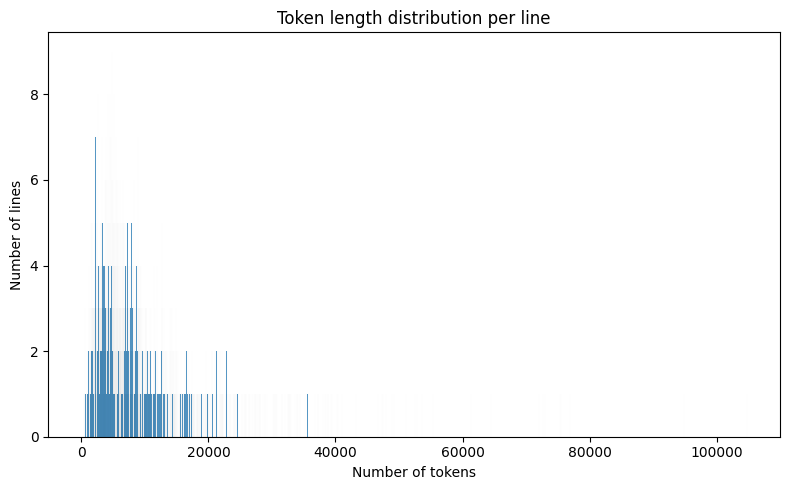

Total lines: 2523
Mean tokens per line: 8339.7
Max tokens in a line: 104746
Min tokens in a line: 419


In [4]:

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(token_lengths, bins=range(0, max(token_lengths)+10, 10), kde=False)
plt.title("Token length distribution per line")
plt.xlabel("Number of tokens")
plt.ylabel("Number of lines")
plt.tight_layout()
plt.show()

# Optional: print some stats
print(f"Total lines: {len(token_lengths)}")
print(f"Mean tokens per line: {sum(token_lengths)/len(token_lengths):.1f}")
print(f"Max tokens in a line: {max(token_lengths)}")
print(f"Min tokens in a line: {min(token_lengths)}")


# Count token with outliers removed

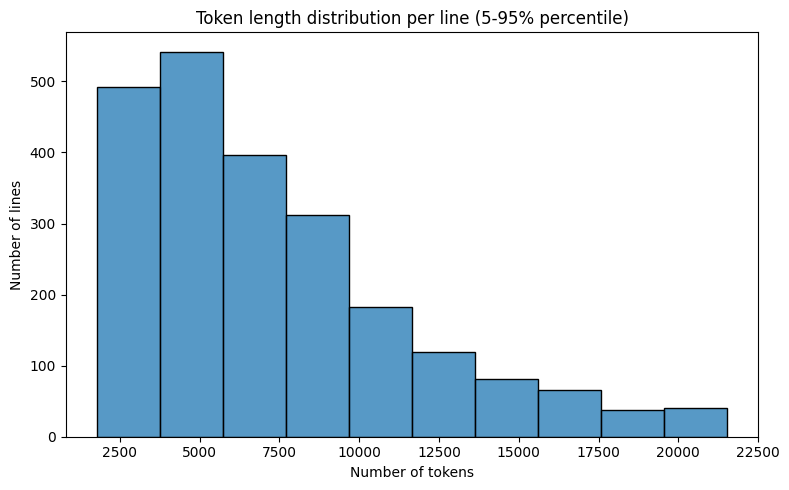

Lines after filtering: 2269
Mean tokens: 7288.2
Min tokens: 1785, Max tokens: 21521


In [6]:
import numpy as np
# Convert to numpy array for percentile calculation
lengths = np.array(token_lengths)

# Compute 5th and 95th percentiles
low, high = np.percentile(lengths, [5, 95])

# Filter lengths between 5th and 95th percentile
filtered_lengths = lengths[(lengths >= low) & (lengths <= high)]

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(filtered_lengths, bins=10, kde=False)
plt.title("Token length distribution per line (5-95% percentile)")
plt.xlabel("Number of tokens")
plt.ylabel("Number of lines")
plt.tight_layout()
plt.show()

# Optional stats
print(f"Lines after filtering: {len(filtered_lengths)}")
print(f"Mean tokens: {filtered_lengths.mean():.1f}")
print(f"Min tokens: {filtered_lengths.min()}, Max tokens: {filtered_lengths.max()}")

In [1]:
from transformers import AutoTokenizer
import os
import re

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")  # replace with your model

input_file = "cleaned_descriptions_trimmed.txt"
output_file = "cleaned_descriptions_1024.txt"
max_tokens = 1024

sentence_end_re = re.compile(r'\. ')

def truncate_to_max_tokens(text, max_tokens):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if len(tokens) <= max_tokens:
        return text

    # Decode truncated token slice
    truncated_tokens = tokens[:max_tokens]
    truncated_text = tokenizer.decode(truncated_tokens, skip_special_tokens=True)

    # Cut at last period followed by space
    matches = list(sentence_end_re.finditer(truncated_text))
    if matches:
        last_end = matches[-1].end()
        truncated_text = truncated_text[:last_end].strip()

    return truncated_text


with open(input_file, "r", encoding="utf-8") as f_in, \
     open(output_file, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line = line.strip()
        if not line:
            continue
        truncated_line = truncate_to_max_tokens(line, max_tokens)
        if truncated_line:
            f_out.write(truncated_line + "\n")

print(f"Truncated lines saved to {output_file}")


Truncated lines saved to cleaned_descriptions_1024.txt


In [2]:
import os

input_file = "cleaned_descriptions_1024.txt"
output_folder = "split_lines"

# Create folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

with open(input_file, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue
        # Create a filename for each line
        out_file = os.path.join(output_folder, f"doc_{idx:05d}.txt")
        with open(out_file, "w", encoding="utf-8") as f_out:
            f_out.write(line + "\n")

print(f"Split {idx} lines into individual files in '{output_folder}'")


Split 2523 lines into individual files in 'split_lines'
